In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from prophet import Prophet

### Loading datasets

In [6]:
def load_data(file_path1, file_path2):
    df1 = pd.read_csv(file_path1)  # All countries global temperature
    df2 = pd.read_csv(file_path2)  # Average Surface Temperature
    return df1, df2

file_path1 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\all countries global temperature.csv"
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df1, df2 = load_data(file_path1, file_path2)

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def predict_temperatures(country, target_year):
    """
    Predict temperature for a given country and year (2022-2030)
    Returns actual history and predicted values
    """
    # Load and prepare data
    df = pd.read_csv("average_surface_temperature_predictions_2022_2030.csv")
    
    # Filter for selected country
    country_data = df[df['Country Name'] == country]
    
    if country_data.empty:
        return None, None, f"Data not available for {country}"
    
    # Get historical and predicted values
    historical = df2[df2['Country Name'] == country].groupby('year')['Average surface temperature'].mean()
    predicted = country_data.iloc[:, :-1].T
    predicted.columns = ['Predicted']
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(historical.index, historical.values, label='Historical', marker='o')
    plt.plot(predicted.index.astype(int), predicted['Predicted'], label='Predicted', marker='x')
    plt.title(f"Temperature Trends for {country}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Get specific prediction if target year provided
    if target_year:
        try:
            year_pred = predicted.loc[str(target_year)][0]
            return historical, predicted, f"Predicted {target_year} temperature: {year_pred:.2f}°C"
        except KeyError:
            return historical, predicted, "Prediction only available for 2022-2030"
    
    return historical, predicted, None

In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the dataset
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df2 = pd.read_csv(file_path2)

# Verify column names
print("Columns in df2:", df2.columns.tolist())

# Convert Day column to datetime and extract month
df2['Day'] = pd.to_datetime(df2['Day'])
df2['month'] = df2['Day'].dt.month

# Calculate yearly averages - using 'Entity' instead of 'Country Name'
yearly_avg = df2.groupby(['Entity', 'year'])['Average surface temperature'].mean().reset_index()

# List of entities (countries)
entities = df2['Entity'].unique().tolist()

# Create widgets
entity_dropdown = widgets.Dropdown(
    options=entities,
    description='Select Entity:',
    value='Kenya'  # Default value
)

analysis_type = widgets.RadioButtons(
    options=['Yearly Trend', 'Monthly Trend', 'Forecast'],
    description='Analysis Type:',
    disabled=False
)

year_range_slider = widgets.IntRangeSlider(
    value=[1980, 2020],
    min=df2['year'].min(),
    max=df2['year'].max(),
    step=1,
    description='Year Range:',
    continuous_update=False
)

plot_button = widgets.Button(description="Generate Plot")
output = widgets.Output()

# Function to plot yearly trend
def plot_yearly_trend(entity, year_range):
    entity_data = yearly_avg[
        (yearly_avg['Entity'] == entity) & 
        (yearly_avg['year'] >= year_range[0]) & 
        (yearly_avg['year'] <= year_range[1])
    ]
    
    if not entity_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(entity_data['year'], entity_data['Average surface temperature'], 
                marker='o', label=entity)
        plt.title(f"Yearly Average Surface Temperature for {entity}")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.grid()
        plt.legend()
        plt.show()
    else:
        print("No data available for the selected parameters.")

# Function to plot monthly trend
def plot_monthly_trend(entity, year_range):
    entity_data = df2[
        (df2['Entity'] == entity) & 
        (df2['year'] >= year_range[0]) & 
        (df2['year'] <= year_range[1])
    ]
    
    if not entity_data.empty:
        monthly_avg = entity_data.groupby('month')['Average surface temperature'].mean()
        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
        plt.figure(figsize=(12, 6))
        plt.plot(months, monthly_avg, marker='o')
        plt.title(f"Monthly Average Temperature for {entity} ({year_range[0]}-{year_range[1]})")
        plt.xlabel("Month")
        plt.ylabel("Temperature (°C)")
        plt.grid()
        plt.show()
    else:
        print("No data available for the selected parameters.")

# Function to generate forecast
def generate_forecast(entity, years_to_forecast=10):
    entity_data = yearly_avg[yearly_avg['Entity'] == entity]
    
    if not entity_data.empty:
        # Prepare data for Prophet
        prophet_data = entity_data[['year', 'Average surface temperature']].rename(
            columns={'year': 'ds', 'Average surface temperature': 'y'})
        prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')
        
        # Train model
        model = Prophet(yearly_seasonality=True)
        model.fit(prophet_data)
        
        # Make future dataframe
        future = model.make_future_dataframe(periods=years_to_forecast, freq='Y')
        forecast = model.predict(future)
        
        # Plot forecast
        fig = model.plot(forecast)
        plt.title(f"Temperature Forecast for {entity}")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.show()
        
        # Plot components
        fig2 = model.plot_components(forecast)
        plt.show()
    else:
        print("No data available for forecasting.")

# Button click handler
def on_plot_button_click(b):
    with output:
        output.clear_output()
        entity = entity_dropdown.value
        year_range = year_range_slider.value
        
        if analysis_type.value == 'Yearly Trend':
            plot_yearly_trend(entity, year_range)
        elif analysis_type.value == 'Monthly Trend':
            plot_monthly_trend(entity, year_range)
        elif analysis_type.value == 'Forecast':
            generate_forecast(entity)

plot_button.on_click(on_plot_button_click)

# Display widgets
display(widgets.VBox([
    widgets.HBox([entity_dropdown, analysis_type]),
    year_range_slider,
    plot_button,
    output
]))

Columns in df2: ['Entity', 'Code', 'year', 'Day', 'Average surface temperature', 'Average surface temperature.1']


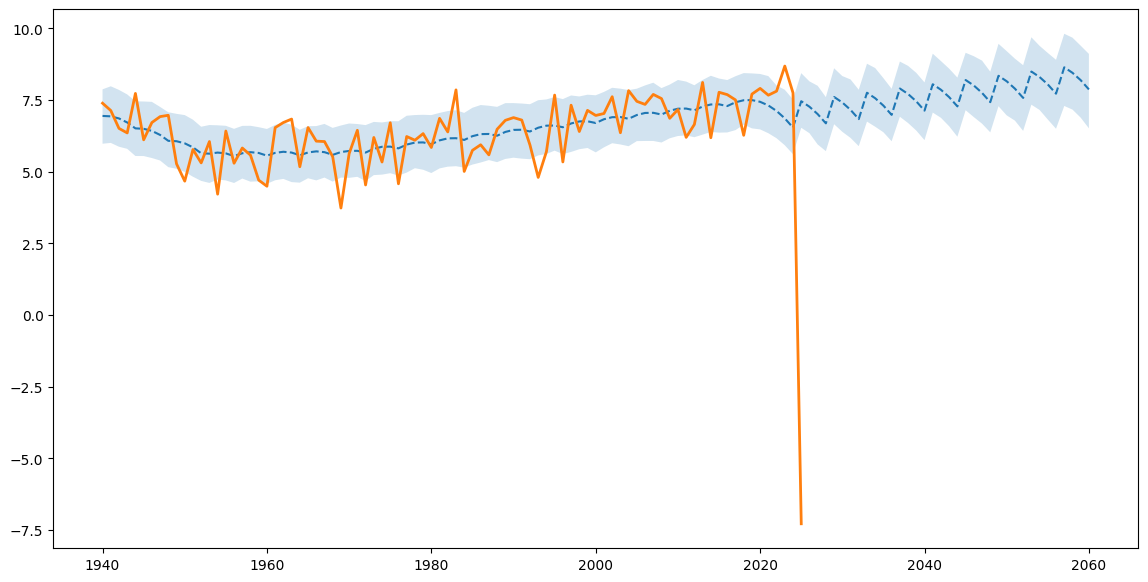

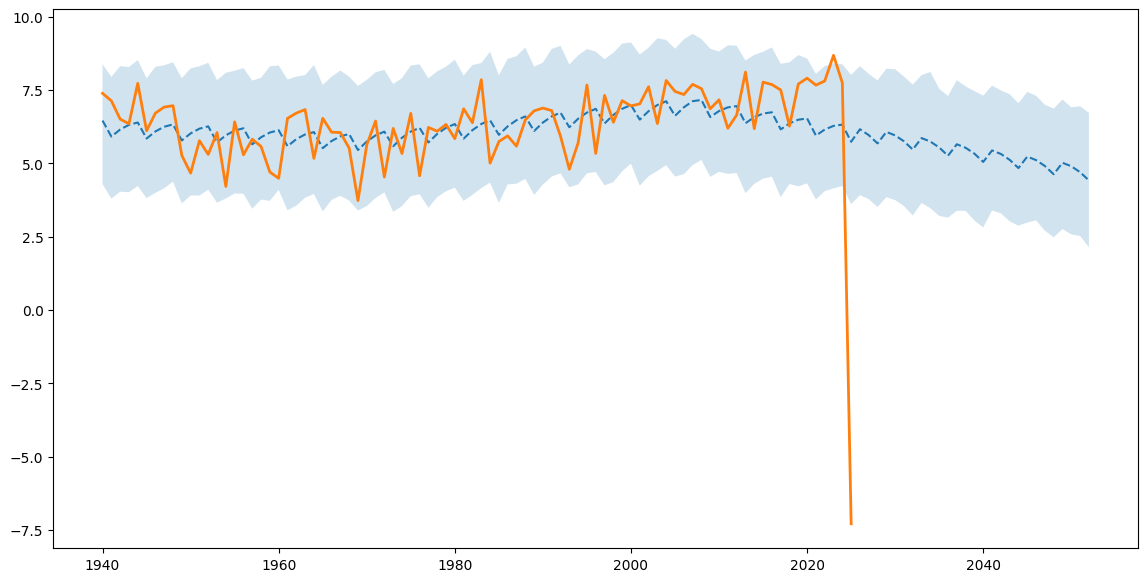

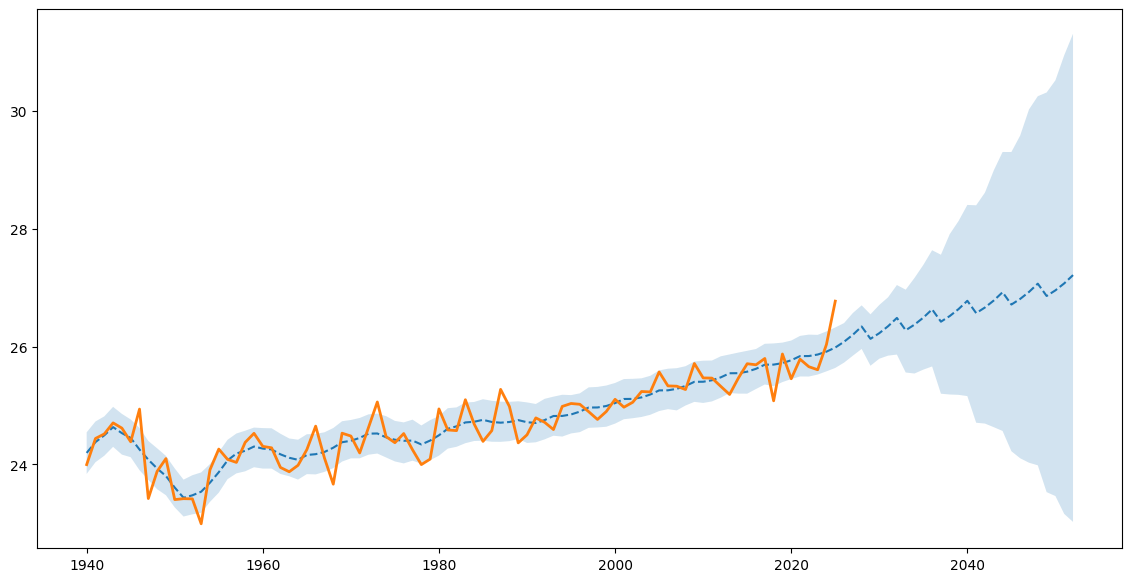

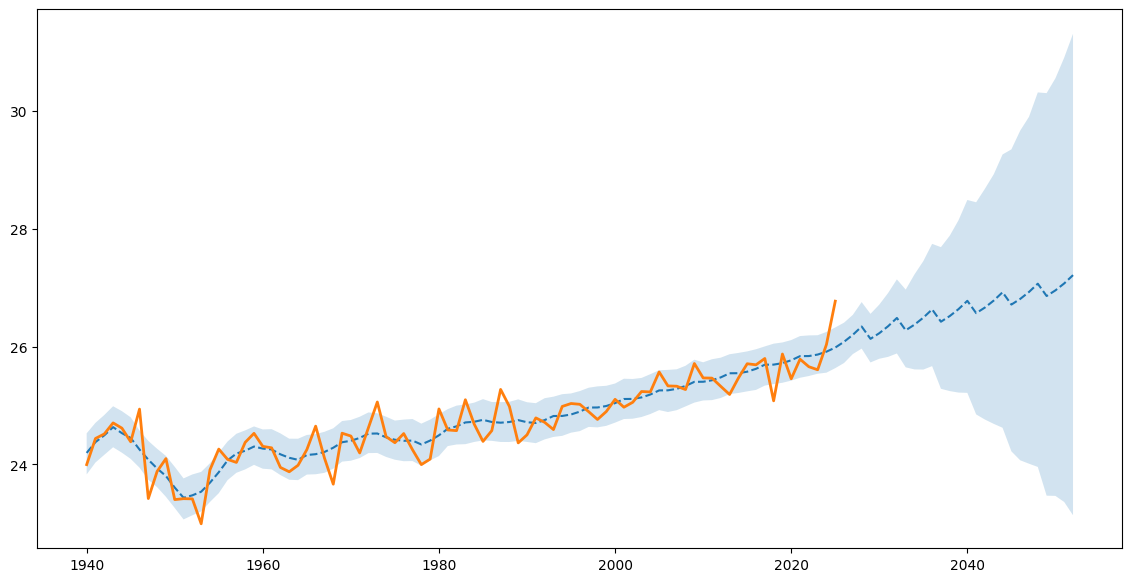

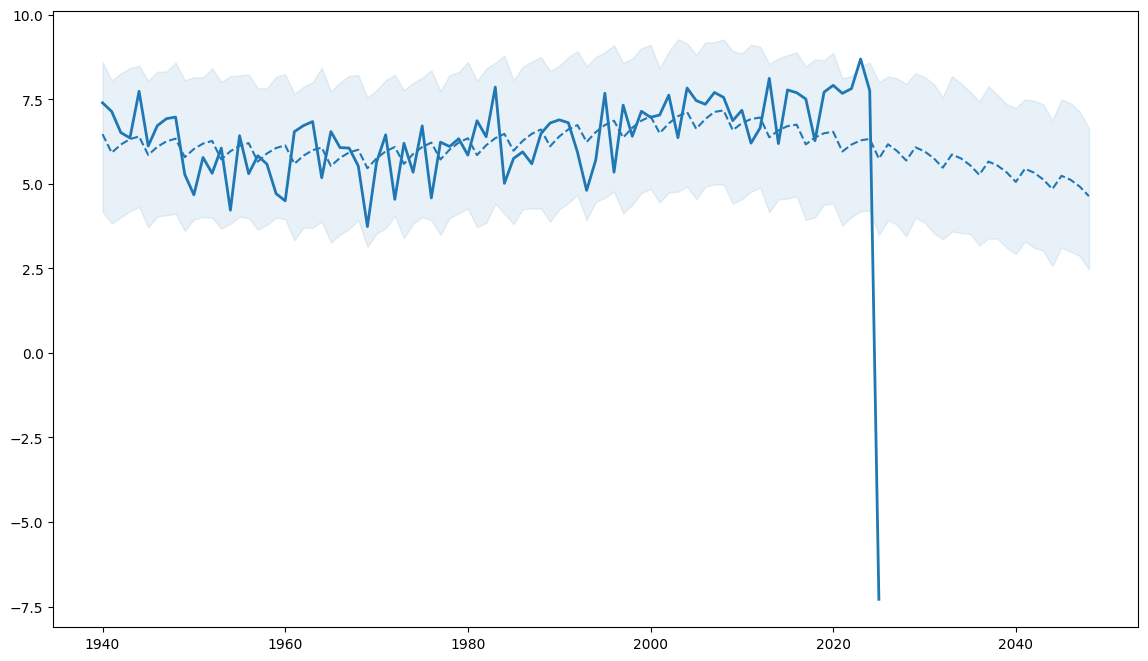

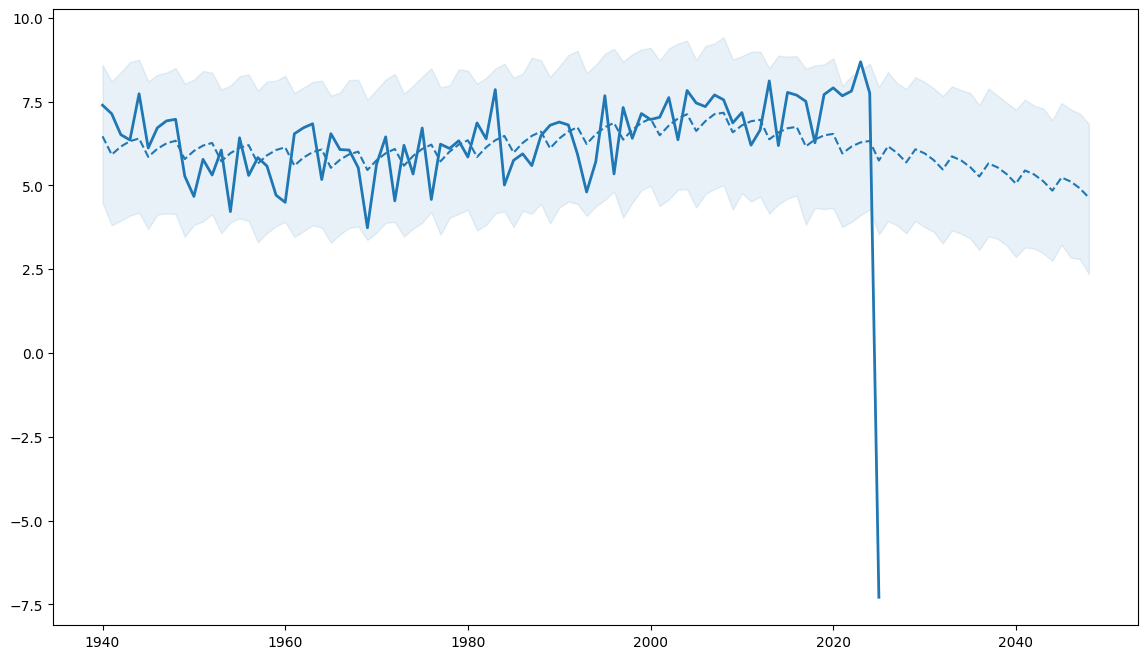

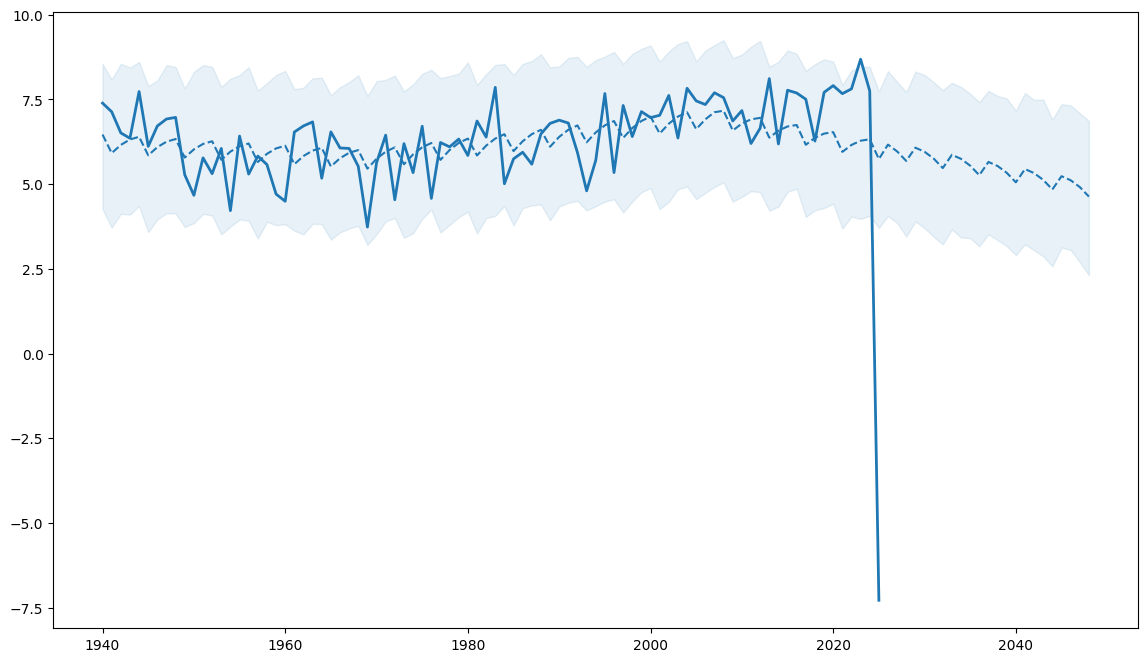

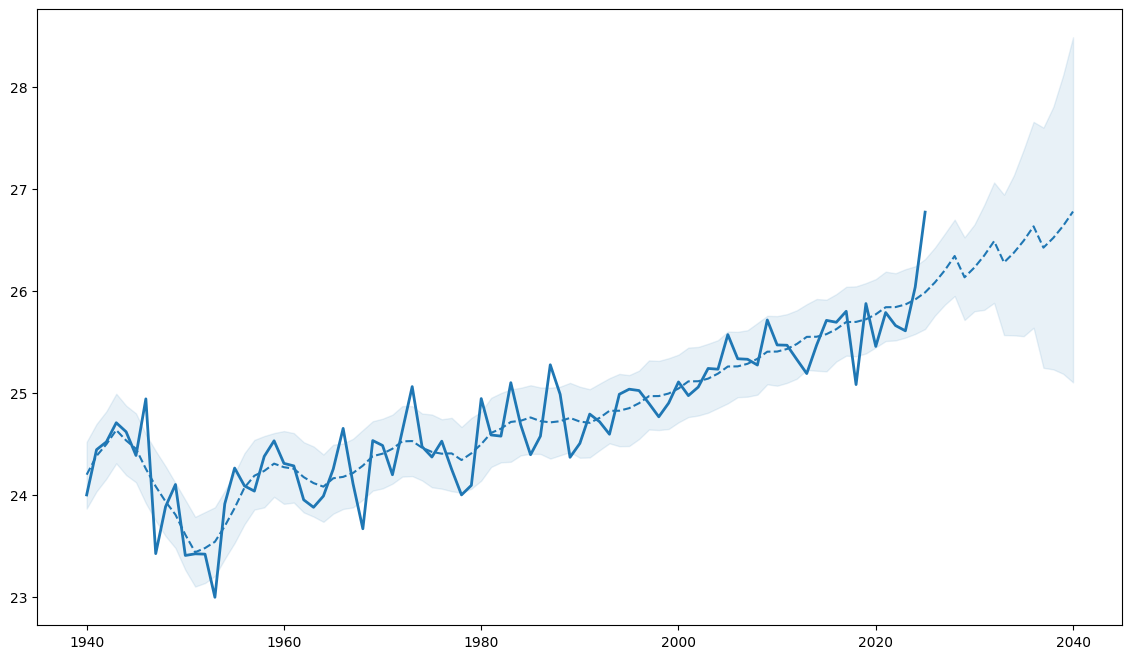

In [26]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the dataset
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df2 = pd.read_csv(file_path2)

# Convert Day column to datetime and extract month/year
df2['Day'] = pd.to_datetime(df2['Day'])
df2['month'] = df2['Day'].dt.month
df2['year'] = df2['Day'].dt.year

# Calculate yearly averages
yearly_avg = df2.groupby(['Entity', 'year'])['Average surface temperature'].mean().reset_index()

# List of entities (countries)
entities = sorted(df2['Entity'].unique().tolist())

# Create widgets
entity_select = widgets.SelectMultiple(
    options=entities,
    description='Select Countries:',
    value=['Kenya'],  # Default selection
    rows=10,
    disabled=False
)

analysis_type = widgets.RadioButtons(
    options=['Yearly Trend', 'Monthly Trend', 'Forecast to 2060'],
    description='Analysis Type:',
    disabled=False
)

year_range_slider = widgets.IntRangeSlider(
    value=[1980, 2020],
    min=df2['year'].min(),
    max=df2['year'].max(),
    step=1,
    description='Year Range:',
    continuous_update=False
)

forecast_start_slider = widgets.IntSlider(
    value=2020,
    min=1980,
    max=2050,
    step=1,
    description='Forecast Start:',
    disabled=False
)

plot_button = widgets.Button(description="Generate Plot", button_style='success')
output = widgets.Output()

# Function to plot yearly trend for multiple countries
def plot_yearly_trend(entities, year_range):
    plt.figure(figsize=(14, 7))
    
    for entity in entities:
        entity_data = yearly_avg[
            (yearly_avg['Entity'] == entity) & 
            (yearly_avg['year'] >= year_range[0]) & 
            (yearly_avg['year'] <= year_range[1])
        ]
        
        if not entity_data.empty:
            plt.plot(entity_data['year'], entity_data['Average surface temperature'], 
                    marker='o', label=entity, linewidth=2)
    
    if entities:
        plt.title(f"Yearly Average Surface Temperature ({year_range[0]}-{year_range[1]})")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Please select at least one country.")

# Function to plot monthly trend for multiple countries
def plot_monthly_trend(entities, year_range):
    plt.figure(figsize=(14, 7))
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for entity in entities:
        entity_data = df2[
            (df2['Entity'] == entity) & 
            (df2['year'] >= year_range[0]) & 
            (df2['year'] <= year_range[1])
        ]
        
        if not entity_data.empty:
            monthly_avg = entity_data.groupby('month')['Average surface temperature'].mean()
            plt.plot(months, monthly_avg, marker='o', label=entity, linewidth=2)
    
    if entities:
        plt.title(f"Monthly Average Temperature ({year_range[0]}-{year_range[1]})")
        plt.xlabel("Month")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Please select at least one country.")

# Function to generate forecast for multiple countries
def generate_forecast(entities, forecast_start):
    plt.figure(figsize=(14, 7))
    forecast_results = {}
    
    for entity in entities:
        entity_data = yearly_avg[yearly_avg['Entity'] == entity]
        
        if not entity_data.empty:
            # Prepare data for Prophet
            prophet_data = entity_data[['year', 'Average surface temperature']].rename(
                columns={'year': 'ds', 'Average surface temperature': 'y'})
            prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')
            
            # Filter data up to forecast start year
            train_data = prophet_data[prophet_data['ds'].dt.year <= forecast_start]
            
            if len(train_data) > 2:  # Need at least 3 points for forecasting
                model = Prophet(
                    yearly_seasonality=True,
                    changepoint_prior_scale=0.5,
                    seasonality_prior_scale=10.0
                )
                model.fit(train_data)
                
                # Make future dataframe extending to 2060
                future_years = 2060 - forecast_start
                future = model.make_future_dataframe(periods=future_years, freq='Y')
                forecast = model.predict(future)
                
                # Plot forecast
                plt.plot(forecast['ds'], forecast['yhat'], label=f"{entity} (forecast)", linestyle='--')
                plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.2)
                
                # Plot historical data
                plt.plot(prophet_data['ds'], prophet_data['y'], label=f"{entity} (historical)", linewidth=2)
                
                # Store forecast results
                forecast_results[entity] = {
                    '2023': entity_data[entity_data['year'] == 2023]['Average surface temperature'].values[0] if 2023 in entity_data['year'].values else None,
                    '2060': forecast[forecast['ds'].dt.year == 2060]['yhat'].values[0]
                }
    
    if entities and forecast_results:
        plt.title(f"Temperature Forecast to 2060 (Starting from {forecast_start})")
        plt.xlabel("Year")
        plt.ylabel("Temperature (°C)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Display forecast summary table
        print("\nForecast Summary (Temperature in °C):")
        summary_df = pd.DataFrame.from_dict(forecast_results, orient='index')
        summary_df['Change (2060-2023)'] = summary_df['2060'] - summary_df['2023']
        display(summary_df.style.format("{:.2f}").background_gradient(cmap='coolwarm'))
    else:
        print("No valid data available for forecasting the selected countries.")

# Button click handler
def on_plot_button_click(b):
    with output:
        output.clear_output()
        selected_entities = list(entity_select.value)
        year_range = year_range_slider.value
        forecast_start = forecast_start_slider.value
        
        if analysis_type.value == 'Yearly Trend':
            plot_yearly_trend(selected_entities, year_range)
        elif analysis_type.value == 'Monthly Trend':
            plot_monthly_trend(selected_entities, year_range)
        elif analysis_type.value == 'Forecast to 2060':
            generate_forecast(selected_entities, forecast_start)

plot_button.on_click(on_plot_button_click)

# Create a tabbed interface
tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        widgets.HBox([entity_select, analysis_type]),
        year_range_slider,
        forecast_start_slider,
        plot_button
    ]),
    output
]
tab.set_title(0, 'Controls')
tab.set_title(1, 'Results')

# Display the interface
display(tab)

In [28]:
def generate_forecast(entities, forecast_start):
    plt.figure(figsize=(14, 8))
    plot_title = f"Long-Term Temperature Projections (from {forecast_start} to 2060)"
    forecast_results = {}
    
    for entity in entities:
        entity_data = yearly_avg[yearly_avg['Entity'] == entity]
        
        if not entity_data.empty:
            color = get_country_color(entity, entities)
            
            # Prepare data for Prophet
            prophet_data = entity_data[['year', 'Average surface temperature']].rename(
                columns={'year': 'ds', 'Average surface temperature': 'y'})
            prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')
            
            # Filter data up to forecast start year
            train_data = prophet_data[prophet_data['ds'].dt.year <= forecast_start]
            
            if len(train_data) > 2:
                model = Prophet(
                    yearly_seasonality=True,
                    changepoint_prior_scale=0.5,
                    seasonality_prior_scale=10.0
                )
                model.fit(train_data)
                
                # Calculate years to forecast (ensure we reach 2060)
                future_years = max(2060 - forecast_start, 1)  # At least 1 year
                future = model.make_future_dataframe(periods=future_years, freq='YE')  # Changed to 'YE'
                forecast = model.predict(future)
                
                # Verify we have data for 2060
                forecast_2060 = forecast[forecast['ds'].dt.year == 2060]
                has_2060 = not forecast_2060.empty
                
                # Plot forecast
                plt.plot(forecast['ds'], forecast['yhat'], 
                        label=f"{entity} (projection)", 
                        linestyle='--', 
                        color=color)
                plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                               alpha=0.1, color=color)
                
                # Plot historical data
                plt.plot(prophet_data['ds'], prophet_data['y'], 
                        label=f"{entity} (historical)", 
                        linewidth=2, 
                        color=color)
                
                # Get current temperature (use last available year if 2023 doesn't exist)
                current_temp = None
                if not entity_data.empty:
                    last_year = entity_data['year'].max()
                    current_temp = entity_data[entity_data['year'] == last_year]['Average surface temperature'].values[0]
                
                # Store forecast results
                forecast_results[entity] = {
                    'Last Available Year': last_year,
                    f'Temperature ({last_year})': current_temp,
                    'Projected 2060': forecast_2060['yhat'].values[0] if has_2060 else None,
                    'Change': (forecast_2060['yhat'].values[0] - current_temp) if has_2060 else None
                }
    
    if entities and forecast_results:
        plt.title(plot_title, fontsize=14, pad=20)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        # Add visual key
        key_elements = {
            "Solid Line": "color: #333; border-bottom: 2px solid #333; width: 30px; display: inline-block;",
            "Dashed Line": "color: #333; border-bottom: 2px dashed #333; width: 30px; display: inline-block;",
            "Shaded Area": "color: #333; background: rgba(0,0,0,0.1); width: 30px; display: inline-block; border-radius: 3px;",
            "Historical Data": "color: #333;",
            "Projection with Uncertainty": "color: #333;"
        }
        add_visual_key(plot_title, key_elements)
        
        plt.show()
        
        # Display forecast summary
        print("\nForecast Summary (Temperature in °C):")
        summary_df = pd.DataFrame.from_dict(forecast_results, orient='index')
        
        # Only apply gradient if we have change values
        if not all(pd.isna(summary_df['Change'])):
            display(summary_df.style.format("{:.2f}").background_gradient(cmap='coolwarm', subset=['Change']))
        else:
            display(summary_df.style.format("{:.2f}"))
        
        # Add interpretation note
        display(HTML(f"""
        <div style='background:#f8f9fa;padding:10px;border-radius:5px;margin:10px;'>
            <h4 style='margin-top:0;'>Interpretation Guide</h4>
            <p><strong>Historical Data:</strong> Verified temperature measurements up to {forecast_start}</p>
            <p><strong>Projections:</strong> Model forecasts through 2060 with shaded uncertainty ranges</p>
            <p><strong>Positive Change Values:</strong> Indicate warming trend by 2060</p>
            <p><strong>Negative Change Values:</strong> Indicate cooling trend by 2060</p>
            <p><strong>Note:</strong> Some countries may not have projections extending to 2060 due to limited historical data</p>
        </div>
        """))
    else:
        print("No valid data available for forecasting the selected countries.")

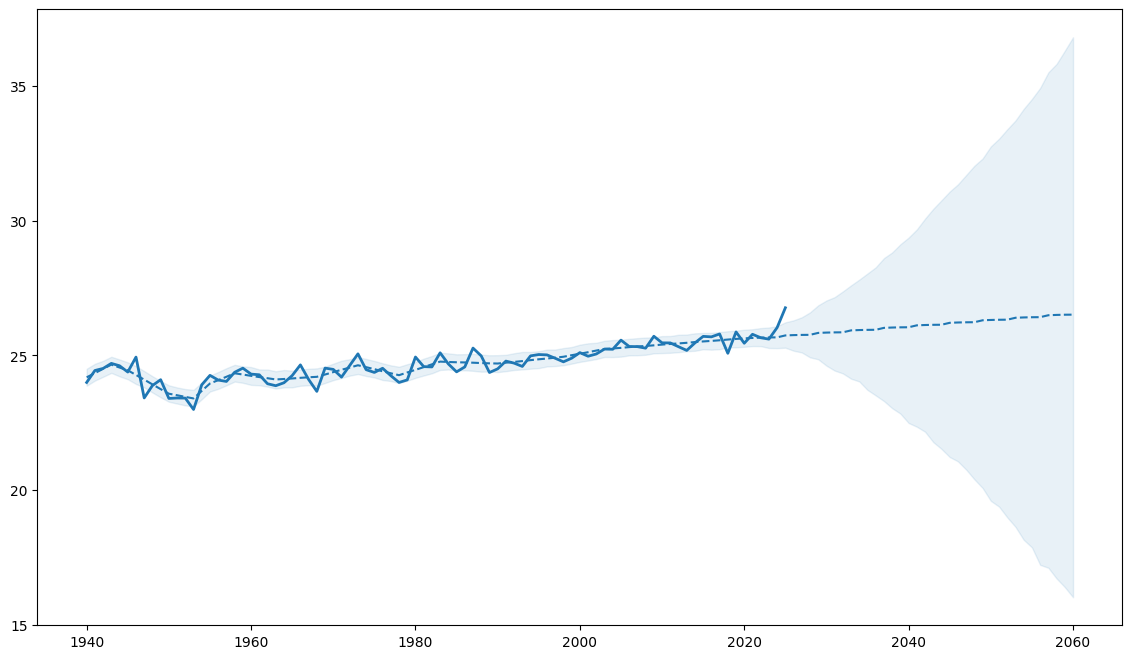

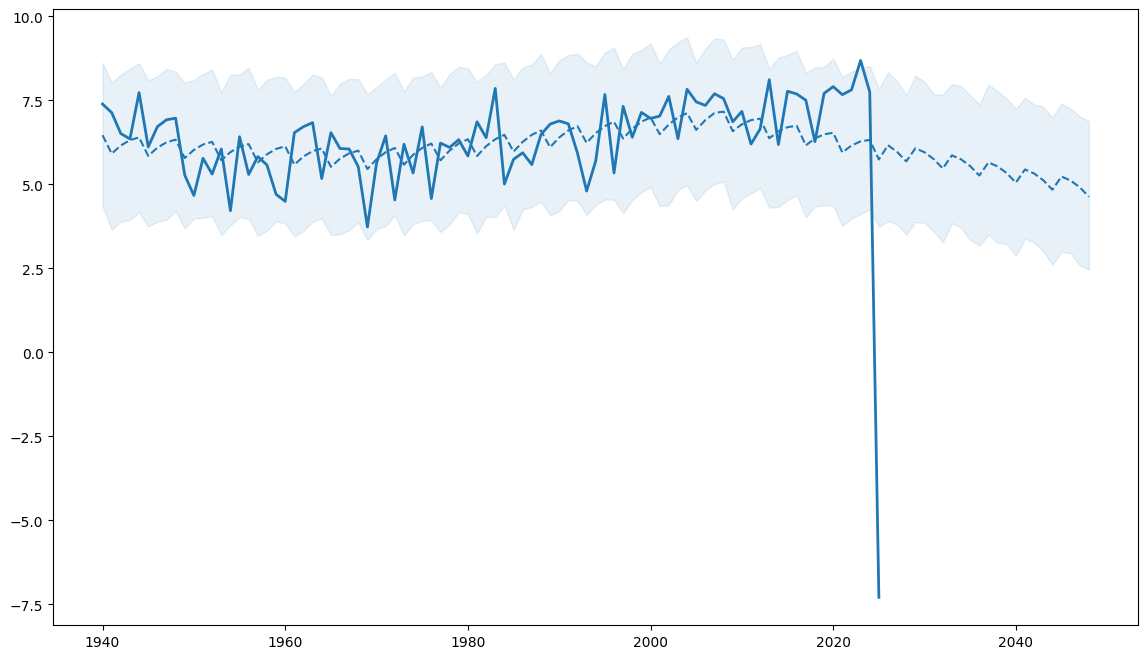

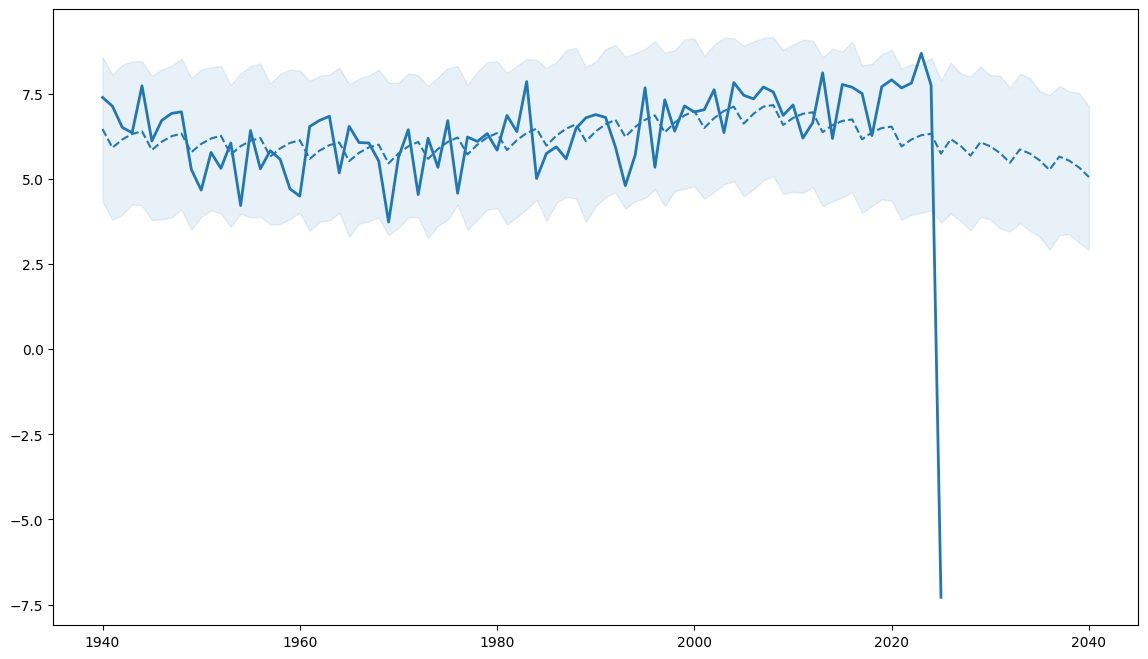

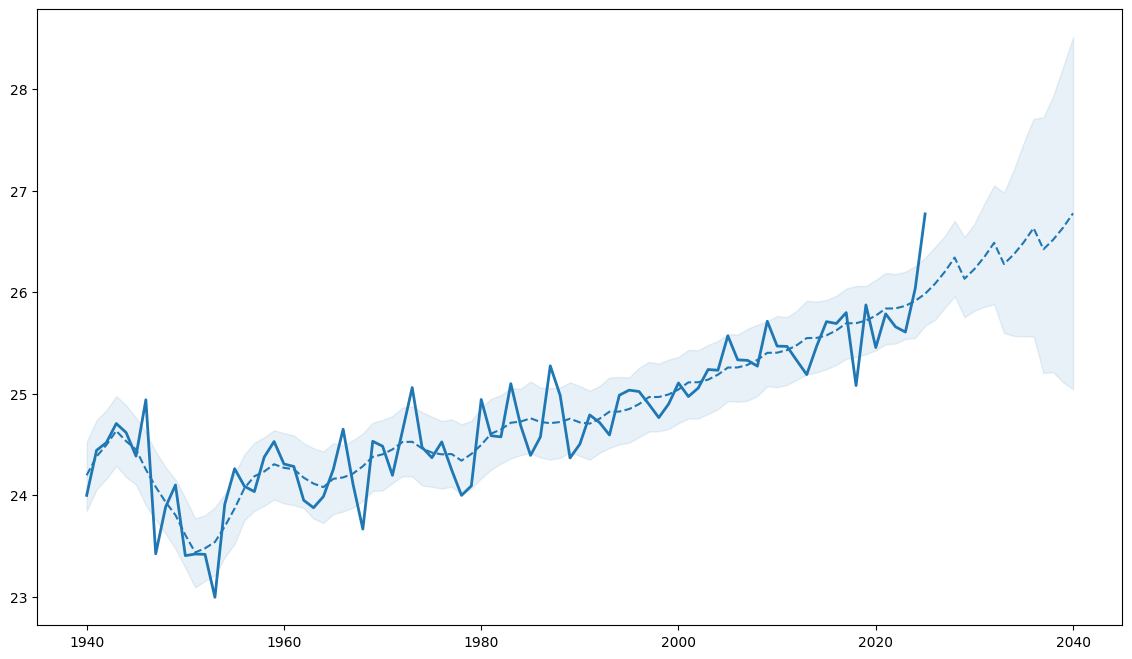

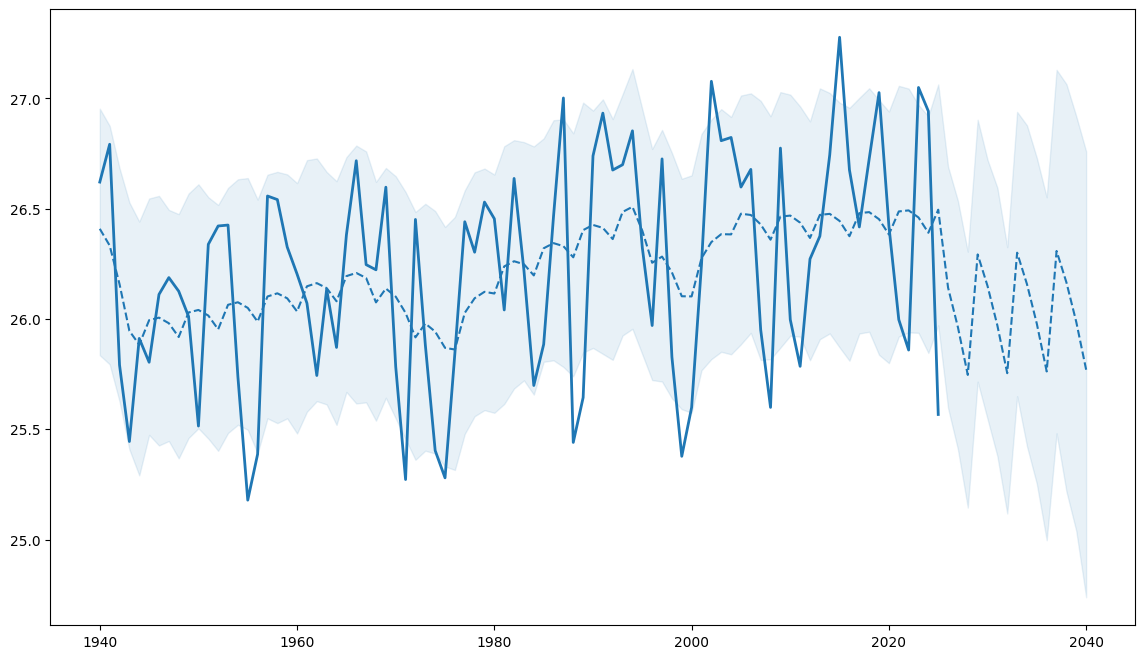

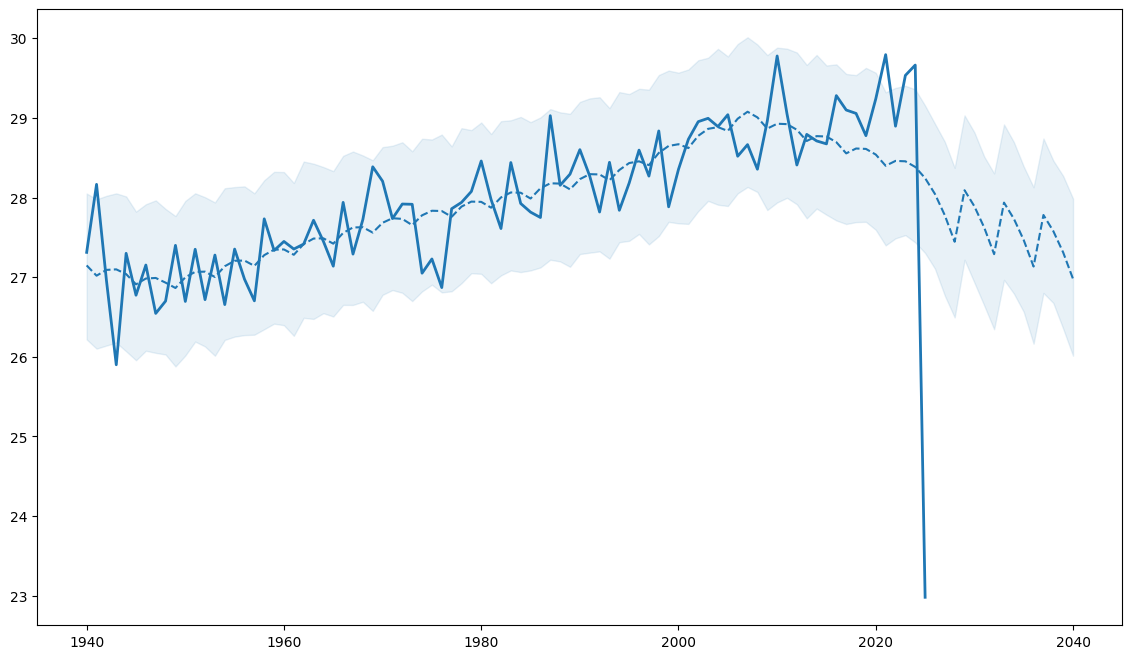

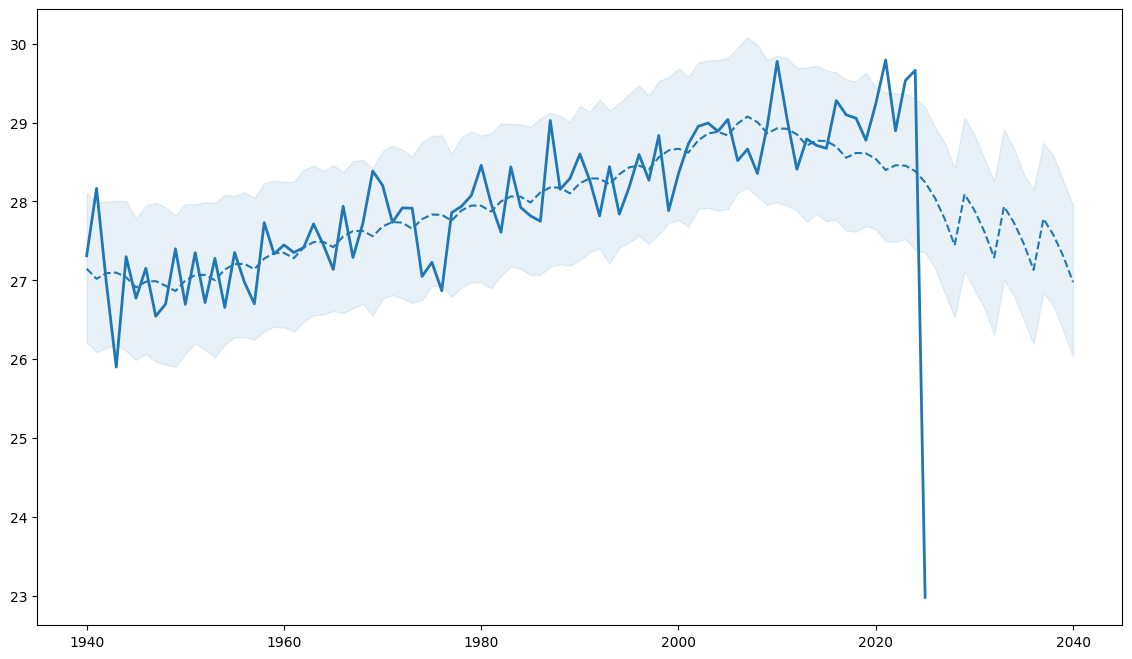

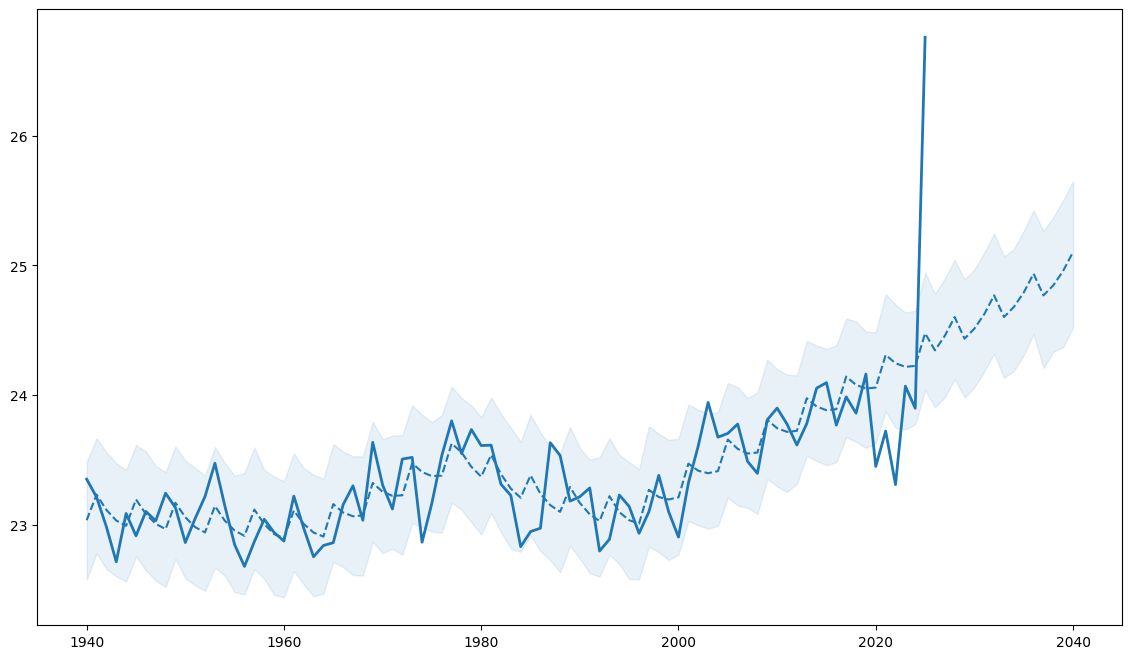

In [29]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from prophet import Prophet

# Load the dataset
file_path2 = r"C:\Users\chris.mutuku\OneDrive - Skanem AS\Desktop\CAPSTONE PROJECT\Capstone-Project---Group-8\Data\Climate Change - datasets\Average Surface Temperature.csv"
df2 = pd.read_csv(file_path2)

# Convert Day column to datetime and extract month/year
df2['Day'] = pd.to_datetime(df2['Day'])
df2['month'] = df2['Day'].dt.month
df2['year'] = df2['Day'].dt.year

# Calculate yearly averages
yearly_avg = df2.groupby(['Entity', 'year'])['Average surface temperature'].mean().reset_index()

# List of entities (countries)
entities = sorted(df2['Entity'].unique().tolist())

# Create widgets
entity_select = widgets.SelectMultiple(
    options=entities,
    description='Select Countries:',
    value=['Kenya', 'United States', 'China'],  # Default selections
    rows=10,
    disabled=False
)

analysis_type = widgets.RadioButtons(
    options=['Yearly Trend', 'Monthly Trend', 'Forecast to 2060'],
    description='Analysis Type:',
    disabled=False
)

year_range_slider = widgets.IntRangeSlider(
    value=[1980, 2020],
    min=df2['year'].min(),
    max=df2['year'].max(),
    step=1,
    description='Year Range:',
    continuous_update=False
)

forecast_start_slider = widgets.IntSlider(
    value=2020,
    min=1980,
    max=2050,
    step=1,
    description='Forecast Start:',
    disabled=False
)

plot_button = widgets.Button(description="Generate Plot", button_style='success')
output = widgets.Output()

# Color palette for consistent country coloring
COLOR_PALETTE = plt.cm.tab20.colors

def get_country_color(entity, entities):
    """Assign consistent color to each country"""
    return COLOR_PALETTE[entities.index(entity) % len(COLOR_PALETTE)]

def add_visual_key(plot_title, elements):
    """Add a visual key/legend box to the plot"""
    key_text = f"<div style='background:#f8f9fa;padding:10px;border-radius:5px;margin:10px;'>"
    key_text += f"<h4 style='margin-top:0;'>Visual Key: {plot_title}</h4>"
    for label, style in elements.items():
        key_text += f"<p><span style='{style}'></span> {label}</p>"
    key_text += "</div>"
    display(HTML(key_text))

# Function to plot yearly trend for multiple countries
def plot_yearly_trend(entities, year_range):
    plt.figure(figsize=(14, 8))
    plot_title = f"Annual Temperature Trends ({year_range[0]}-{year_range[1]})"
    
    for entity in entities:
        entity_data = yearly_avg[
            (yearly_avg['Entity'] == entity) & 
            (yearly_avg['year'] >= year_range[0]) & 
            (yearly_avg['year'] <= year_range[1])
        ]
        
        if not entity_data.empty:
            color = get_country_color(entity, entities)
            plt.plot(entity_data['year'], entity_data['Average surface temperature'], 
                    marker='o', label=entity, linewidth=2, color=color)
    
    if entities:
        plt.title(plot_title, fontsize=14, pad=20)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        # Add visual key
        key_elements = {
            "Solid Line": "color: #333; border-bottom: 2px solid #333; width: 30px; display: inline-block;",
            "Circle Marker": "color: #333; display: inline-block; width: 10px; height: 10px; border-radius: 50%; border: 2px solid #333; background: white;",
            "Each country has unique color": "color: #333;"
        }
        add_visual_key(plot_title, key_elements)
        
        plt.show()
    else:
        print("Please select at least one country.")

# Function to plot monthly trend for multiple countries
def plot_monthly_trend(entities, year_range):
    plt.figure(figsize=(14, 8))
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plot_title = f"Seasonal Temperature Patterns ({year_range[0]}-{year_range[1]})"
    
    for entity in entities:
        entity_data = df2[
            (df2['Entity'] == entity) & 
            (df2['year'] >= year_range[0]) & 
            (df2['year'] <= year_range[1])
        ]
        
        if not entity_data.empty:
            color = get_country_color(entity, entities)
            monthly_avg = entity_data.groupby('month')['Average surface temperature'].mean()
            plt.plot(months, monthly_avg, marker='o', label=entity, linewidth=2, color=color)
    
    if entities:
        plt.title(plot_title, fontsize=14, pad=20)
        plt.xlabel("Month", fontsize=12)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        # Add visual key
        key_elements = {
            "Line Chart": "color: #333; border-bottom: 2px solid #333; width: 30px; display: inline-block;",
            "Points show monthly averages": "color: #333;",
            "Pattern shows seasonal variation": "color: #333;"
        }
        add_visual_key(plot_title, key_elements)
        
        plt.show()
    else:
        print("Please select at least one country.")

# Function to generate forecast for multiple countries
def generate_forecast(entities, forecast_start):
    plt.figure(figsize=(14, 8))
    plot_title = f"Long-Term Temperature Projections (to 2060)"
    forecast_results = {}
    
    for entity in entities:
        entity_data = yearly_avg[yearly_avg['Entity'] == entity]
        
        if not entity_data.empty:
            color = get_country_color(entity, entities)
            
            # Prepare data for Prophet
            prophet_data = entity_data[['year', 'Average surface temperature']].rename(
                columns={'year': 'ds', 'Average surface temperature': 'y'})
            prophet_data['ds'] = pd.to_datetime(prophet_data['ds'], format='%Y')
            
            # Filter data up to forecast start year
            train_data = prophet_data[prophet_data['ds'].dt.year <= forecast_start]
            
            if len(train_data) > 2:
                model = Prophet(
                    yearly_seasonality=True,
                    changepoint_prior_scale=0.5,
                    seasonality_prior_scale=10.0
                )
                model.fit(train_data)
                
                future_years = 2060 - forecast_start
                future = model.make_future_dataframe(periods=future_years, freq='Y')
                forecast = model.predict(future)
                
                # Plot forecast
                plt.plot(forecast['ds'], forecast['yhat'], 
                        label=f"{entity} (projection)", 
                        linestyle='--', 
                        color=color)
                plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                               alpha=0.1, color=color)
                
                # Plot historical data
                plt.plot(prophet_data['ds'], prophet_data['y'], 
                        label=f"{entity} (historical)", 
                        linewidth=2, 
                        color=color)
                
                forecast_results[entity] = {
                    '2023': entity_data[entity_data['year'] == 2023]['Average surface temperature'].values[0] if 2023 in entity_data['year'].values else None,
                    '2060': forecast[forecast['ds'].dt.year == 2060]['yhat'].values[0],
                    'Change': forecast[forecast['ds'].dt.year == 2060]['yhat'].values[0] - (entity_data[entity_data['year'] == 2023]['Average surface temperature'].values[0] if 2023 in entity_data['year'].values else None)
                }
    
    if entities and forecast_results:
        plt.title(plot_title, fontsize=14, pad=20)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Temperature (°C)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        # Add visual key
        key_elements = {
            "Solid Line": "color: #333; border-bottom: 2px solid #333; width: 30px; display: inline-block;",
            "Dashed Line": "color: #333; border-bottom: 2px dashed #333; width: 30px; display: inline-block;",
            "Shaded Area": "color: #333; background: rgba(0,0,0,0.1); width: 30px; display: inline-block; border-radius: 3px;",
            "Historical Data": "color: #333;",
            "Projection with Uncertainty": "color: #333;"
        }
        add_visual_key(plot_title, key_elements)
        
        plt.show()
        
        # Display forecast summary
        print("\nForecast Summary (Temperature in °C):")
        summary_df = pd.DataFrame.from_dict(forecast_results, orient='index')
        display(summary_df.style.format("{:.2f}").background_gradient(cmap='coolwarm', subset=['Change']))
        
        # Add interpretation note
        display(HTML("""
        <div style='background:#f8f9fa;padding:10px;border-radius:5px;margin:10px;'>
            <h4 style='margin-top:0;'>Interpretation Guide</h4>
            <p><strong>Historical Data:</strong> Verified temperature measurements</p>
            <p><strong>Projections:</strong> Model forecasts with shaded uncertainty ranges</p>
            <p><strong>Positive Change Values:</strong> Indicate warming trend by 2060</p>
            <p><strong>Negative Change Values:</strong> Indicate cooling trend by 2060</p>
        </div>
        """))
    else:
        print("No valid data available for forecasting the selected countries.")

# Button click handler
def on_plot_button_click(b):
    with output:
        output.clear_output()
        selected_entities = list(entity_select.value)
        year_range = year_range_slider.value
        forecast_start = forecast_start_slider.value
        
        if analysis_type.value == 'Yearly Trend':
            plot_yearly_trend(selected_entities, year_range)
        elif analysis_type.value == 'Monthly Trend':
            plot_monthly_trend(selected_entities, year_range)
        elif analysis_type.value == 'Forecast to 2060':
            generate_forecast(selected_entities, forecast_start)

plot_button.on_click(on_plot_button_click)

# Create a tabbed interface
tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        widgets.HBox([entity_select, analysis_type]),
        year_range_slider,
        forecast_start_slider,
        plot_button
    ]),
    output
]
tab.set_title(0, 'Controls')
tab.set_title(1, 'Results')

# Display the interface
display(tab)